## Summary

----

## Imports

In [1]:
import concurrent.futures
import itertools
import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import proteinsolver
import psutil
import pyarrow as pa
import pyarrow.parquet as pq
import torch
from kmbio import PDB
from scipy import stats
from torch.utils.data import DataLoader, Dataset

In [2]:
DEBUG = "CI" not in os.environ

In [3]:
if DEBUG:
    %load_ext autoreload
    %autoreload 2

## Parameters

In [4]:
UNIQUE_ID = "191f05de"  # No attention
# UNIQUE_ID = "0007604c"  # 5-layer graph-conv with attention, batch_size=1
# UNIQUE_ID = "91fc9ab9"  # 4-layer graph-conv with attention, batch_size=4

In [5]:
BEST_STATE_FILES = {
    #
    "191f05de": "protein_train/191f05de/e53-s1952148-d93703104.state"
}

In [6]:
NOTEBOOK_NAME = "06_global_analysis_of_protein_folding"
NOTEBOOK_PATH = Path(NOTEBOOK_NAME)
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('06_global_analysis_of_protein_folding')

In [7]:
INPUT_PATH = Path(os.getenv("DATAPKG_INPUT_DIR"))
INPUT_PATH

PosixPath('/home/kimlab1/database_data/datapkg_input_dir')

In [8]:
DATAPKG_DATA_DIR = Path(f"~/datapkg_data_dir").expanduser().resolve()
DATAPKG_DATA_DIR

PosixPath('/home/kimlab1/database_data/datapkg_output_dir')

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
proteinsolver.settings.data_url = DATAPKG_DATA_DIR.as_posix()
proteinsolver.settings.data_url

'/home/kimlab1/database_data/datapkg_output_dir'

## Load data

In [11]:
!ls {INPUT_PATH}/global_analysis_of_protein_folding

aan0693_designed-PDB-files	   hhpred
aan0693_designed-PDB-files.gz.zip  hhpred2
aan0693_SI_datasets		   mutation_structures_for_rosetta
aan0693_SI_datasets.tar.gz.zip	   swissmodel


In [12]:
!ls {INPUT_PATH}/global_analysis_of_protein_folding/aan0693_designed-PDB-files

aan0693_designed-PDB-files.gz  nmr  other  other2  rd1	rd2  rd3  rd4


In [13]:
!ls {INPUT_PATH}/global_analysis_of_protein_folding/aan0693_SI_datasets

counts_and_ec50s.tar.gz		  protein_and_dna_sequences.tar.gz
design_scripts.tgz		  stability_scores
design_structural_metrics	  stability_scores.tar.gz
design_structural_metrics.tar.gz  unfolded_state_model_params
fig1_thermodynamic_data.csv


### aan0693_SI_datasets

In [14]:
!ls {INPUT_PATH}/global_analysis_of_protein_folding/aan0693_SI_datasets/stability_scores

rd1_stability_scores  rd3_stability_scores  ssm2_stability_scores
rd2_stability_scores  rd4_stability_scores


In [15]:
def remove_controls(df):
    df = df[
        (~df["name"].str.endswith("_hp")) & (~df["name"].str.endswith("_random")) & (~df["name"].str.endswith("_buryD"))
    ]
    return df

In [16]:
def load_stability_scores(key):
    stability_scores = pd.read_csv(
        INPUT_PATH
        / "global_analysis_of_protein_folding"
        / "aan0693_SI_datasets"
        / "stability_scores"
        / f"{key}_stability_scores",
        sep="\t",
    )
    stability_scores = remove_controls(stability_scores)

    for energy_function in ["talaris2013", "betanov15"]:
        rosetta_energies_file = (
            INPUT_PATH
            / "global_analysis_of_protein_folding"
            / "aan0693_SI_datasets"
            / "design_structural_metrics"
            / f"{key}_relax_scored_{'filtered_' if energy_function == 'betanov15' else ''}{energy_function}.sc"
        )
        if not rosetta_energies_file.is_file():
            print(f"Not loading Rosetta energies for {energy_function}!")
            continue

        before_ = len(stability_scores)
        relax_scored_filtered = pd.read_csv(
            rosetta_energies_file, sep="\t" if energy_function == "betanov15" else " +", engine="python"
        ).rename(columns={"description": "name", "total_score": f"{energy_function}_score"})
        stability_scores = stability_scores.merge(
            relax_scored_filtered[["name", f"{energy_function}_score"]], on="name", how="outer"
        )
#         assert len(stability_scores) == before_, (len(stability_scores), before_)

    stability_scores["library_name"] = key
    return stability_scores

### stability_scores

In [17]:
# stability_scores = {}

In [18]:
# for key in ["rd1", "rd2", "rd3", "rd4", "ssm2"]:
#     print(key)
#     stability_scores[key] = load_stability_scores(key)

In [19]:
# stability_scores["fig1"] = pd.read_csv(
#     INPUT_PATH / "global_analysis_of_protein_folding" / "aan0693_SI_datasets" / "fig1_thermodynamic_data.csv"
# ).assign(library_name="fig1")

In [20]:
# with open(NOTEBOOK_PATH.joinpath("stability_scores.raw.incremental.torch"), "wb") as fout:
#     torch.save(stability_scores, fout)

In [21]:
stability_scores = torch.load(NOTEBOOK_PATH.joinpath("stability_scores.torch"))

In [22]:
stability_scores["rd4"].head()

,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,...,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,ec50_rise_c,stabilityscore_c,stabilityscore,talaris2013_score,betanov15_score,library_name
0,1A11,GSEKMSTAISVLLAQAVFLLLTSQRGSGNGSGGNGSGGNGSGNGSG...,4.0,2.69,2.5,2.9,0.4,3.01,-0.32,-0.15,...,2.4,2.7,0.3,1.41,1.12,0.53,-0.15,NaN,NaN,rd4
1,1AIE,EYFTLQIRGRERFEMFRELNEALELKDAQAGSGNGSGGNGSGGNGS...,4.0,4.07,4.0,4.1,0.1,0.49,3.58,1.71,...,3.9,4.0,0.1,0.61,3.34,1.60,1.60,NaN,NaN,rd4
2,1AMB,DAEFRHDSGYEVHHQKLVFFAEDVGSNKGNGSGGNGSGGNGSGNGS...,4.0,1.24,1.1,1.4,0.3,2.40,-1.16,-0.55,...,-0.5,1.2,1.7,1.47,-1.11,-0.53,-0.55,NaN,NaN,rd4
3,1AMC,DAEFRHDSGYEVHHQKLVFFAEDVGSNKNGSGGNGSGGNGSGNGSG...,4.0,2.42,2.3,2.6,0.3,2.39,0.03,0.01,...,0.6,1.1,0.5,1.47,-0.53,-0.25,-0.25,NaN,NaN,rd4
4,1AML,DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVGSGGNG...,4.0,2.20,2.1,2.3,0.2,2.09,0.10,0.05,...,0.5,1.1,0.6,1.35,-0.49,-0.23,-0.23,NaN,NaN,rd4


## Load model

In [23]:
%run protein_train/{UNIQUE_ID}/model.py

In [24]:
batch_size = 1
num_features = 20
adj_input_size = 2
hidden_size = 128
frac_present = 0.5
frac_present_valid = frac_present
info_size= 1024

In [25]:
state_file = BEST_STATE_FILES[UNIQUE_ID]
state_file

'protein_train/191f05de/e53-s1952148-d93703104.state'

In [26]:
net = Net(
    x_input_size=num_features + 1, adj_input_size=adj_input_size, hidden_size=hidden_size, output_size=num_features
)
net.load_state_dict(torch.load(state_file, map_location=device))
net.eval()
net = net.to(device)

## Structure probabilities

In [27]:
structure_file = "/home/kimlab1/database_data/datapkg_input_dir/global_analysis_of_protein_folding/aan0693_designed-PDB-files/rd1/EEHEE_rd1_0004.pdb"

In [28]:
structure = PDB.load(structure_file)

In [29]:
pdata = proteinsolver.utils.extract_seq_and_adj(structure, 'A')

In [30]:
data = proteinsolver.datasets.protein.row_to_data(pdata)
data = proteinsolver.datasets.protein.transform_edge_attr(data)
data.to(device)

print(
    proteinsolver.utils.get_node_outputs(
        net, data.x, data.edge_index, data.edge_attr, 20, output_transform="logproba"
    )
)

tensor([-2.1866, -2.8192, -0.8576, -3.1876, -6.9420, -1.0521, -0.1976, -1.1227,
        -1.4856, -2.1950, -2.0287, -0.3771, -2.8255, -1.1229, -2.2655, -3.1545,
        -0.8361, -0.3876, -1.8040, -1.5459, -2.0852, -0.1505, -1.7250, -2.2637,
        -3.0158, -0.1281, -0.4505, -3.4455, -3.2797, -0.2760, -1.1259, -2.8295,
        -2.0394, -0.4193, -4.0072, -1.1092, -2.4877, -1.2500, -3.2661, -2.8514,
        -3.5015])


### structure_proba

In [31]:
def get_structure_proba(net, filename):
    try:
        library_name = filename.split("_")[1]
    except IndexError:
        return np.nan, np.nan
    filepath = (
        INPUT_PATH / "global_analysis_of_protein_folding" / "aan0693_designed-PDB-files" / library_name / filename
    )
    if not filepath.is_file():
        return np.nan, np.nan
    structure = PDB.load(filepath)
    pdata = proteinsolver.utils.extract_seq_and_adj(structure, "A")
    data = proteinsolver.datasets.protein.row_to_data(pdata)
    data = proteinsolver.datasets.protein.transform_edge_attr(data)
    data = data.to(device)
    #     log_prob = proteinsolver.utils.get_node_proba(net, data.x, data.edge_index, data.edge_attr, 20)
    log_prob = proteinsolver.utils.get_node_outputs(
        net, data.x, data.edge_index, data.edge_attr, 20, output_transform="logproba"
    )
    return log_prob.sum().item(), len(pdata.sequence)

In [32]:
def get_filepath(filename):
    try:
        library = filename.split("_")[1]
    except IndexError:
        #         print(f"Cound not guess library for file: {filename}!")
        return None
    filepath = INPUT_PATH / "global_analysis_of_protein_folding" / "aan0693_designed-PDB-files" / library / filename
    if not filepath.is_file():
        #         print(f"File {filename} does not exist!")
        return None
    return filepath


class DesignsDataset(Dataset):
    """Face Landmarks dataset."""

    @staticmethod
    def transform(pdata):
        data = proteinsolver.datasets.protein.row_to_data(pdata)
        data = proteinsolver.datasets.protein.transform_edge_attr(data)
        return data

    @staticmethod
    def add_domain(filepath, data):
        domain = filepath.name.split("_")[0]
        data.domain = domain
        return data

    def __init__(self, filenames, sequences, use_ref_graph=True):
        self.use_ref_graph = use_ref_graph

        ref_files = {
            "EEHEE": ("EEHEE_nmr_5up1.cif", "TTVKLGDIKVTFDNPEKAKKYAQKLAKIYQLTVHVHGDTIHVK"),
            "EHEE": ("EHEE_nmr_5up5.cif", "TQTQEFDNEEEARKAEKELRKENRRVTVTQENGRWRVTWD"),
            "HEEH": ("HEEH_nmr_5uyo.cif", "DVEEQIRRLEEVLKKNQPVTWNGTTYTDPNEIKKVIEELRKSM"),
            "HHH": ("HHH_nmr_5uoi.cif", "RKWEEIAERLREEFNINPEEAREAVEKAGGNEEEARRIVKKRL"),
        }
        domains = list({f.split("_")[0] for f in filenames})
        if set(domains) - set(ref_files):
            print(f"Do not have reference for the following domains: {set(domains) - set(ref_files)}!")
        pdata_ref = {}
        for domain, (filename, sequence) in ref_files.items():
            filepath = get_filepath(filename)
            structure = PDB.load(filepath)
            pdata = proteinsolver.utils.extract_seq_and_adj(structure, "A")
            assert pdata.sequence == sequence, (domain, filename, pdata.sequence, sequence)
            pdata_ref[domain] = pdata
        #         pdata_ref["EEHEE"] = pdata_ref["EEHEE"]._replace(sequence=pdata_ref["EEHEE"].sequence + "LESSGGS")
        self.data_ref = {domain: self.transform(pdata) for domain, pdata in pdata_ref.items()}

        self.filepaths, self.sequences = list(
            zip(
                *[
                    (f, s)
                    for f, s in itertools.zip_longest((get_filepath(f) for f in filenames), sequences)
                    if f is not None
                ]
            )
        )

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        sequence = self.sequences[idx]
        structure = PDB.load(filepath)
        pdata = proteinsolver.utils.extract_seq_and_adj(structure, "A")

        name = filepath.name
        domain = filepath.name.split("_")[0]

        start = None
        end = None
        if pd.isnull(sequence):
            pass
        elif pdata.sequence != sequence:
            mismatch_size = len(sequence) - len(pdata.sequence)
            if mismatch_size <= 0:
                print(f"Sequence mismatch of size '{mismatch_size}' for protein {filepath.name}!")
                return name, domain, None
            else:
                for start in range(mismatch_size + 1):
                    end = start + len(pdata.sequence)
                    sequence_slice = sequence[start:end]
                    frac_identical = sum(
                        a1 == a2 for (a1, a2) in itertools.zip_longest(pdata.sequence, sequence_slice)
                    ) / len(pdata.sequence)
                    if frac_identical >= 1.0:
                        break
                if frac_identical < 1.0:
                    print(f"Sequence mismatch for protein {filepath.name}: ({frac_identical:.2%} identical).")
                    return name, domain, None

        data = self.transform(pdata)

        if self.use_ref_graph and data.domain in self.data_ref:
            data_ref = self.data_ref[data.domain].clone()
            if start is not None:
                data_ref.x = data_ref.x[start:end]
                mask = ((data_ref.edge_index >= start) & (data_ref.edge_index < end)).all(dim=0)
                data_ref.edge_index = data_ref.edge_index[:, mask] - start
                data_ref.edge_attr = data_ref.edge_attr[mask, :]
                assert (data_ref.edge_index >= 0).all().item()
                assert (data_ref.edge_index < data_ref.x.size(0)).all().item()

            if data.x.size(0) != data_ref.x.size(0):
                print(f"Reference structure length mismatch for protein {filepath.name}.")
                data.edge_index_ref = None
                data.edge_attr_ref = None
                data.identity_to_ref = None
            else:
                assert data.x.size(0) == data_ref.x.size(0)
                assert data_ref.edge_index.min() >= 0
                assert data_ref.edge_index.max() < data.x.size(0)
                data.edge_index_ref = data_ref.edge_index
                data.edge_attr_ref = data_ref.edge_attr
                data.identity_to_ref = float((data.x == data_ref.x).sum().item()) / data.x.size(0)
        else:
            data.edge_index_ref = data.edge_index
            data.edge_attr_ref = data.edge_attr
            data.identity_to_ref = 1

        return name, domain, data

In [33]:
design_dataset = DesignsDataset(
    stability_scores["rd2"]["name"], stability_scores["rd2"]["sequence"], use_ref_graph=False
)

In [34]:
design_dataset[4000]

('EHEE_rd2_1032.pdb',
 'EHEE',
 Data(edge_attr=[1186, 2], edge_attr_ref=[1186, 2], edge_index=[2, 1186], edge_index_ref=[2, 1186], identity_to_ref=[1], x=[40]))

In [35]:
# for library in ["rd1", "rd2", "rd3", "rd4"]:
#     stability_scores[library]["network_score"], stability_scores[library]["sequence_length"] = np.array(
#         [get_structure_proba(net, name) for name in stability_scores[library]["name"]]
#     ).T

In [36]:
def apply_scores(df):
    results = []
    design_dataset = DesignsDataset(df["name"], df["sequence"], use_ref_graph=False)
    for i, (name, domain, data) in enumerate(
        DataLoader(design_dataset, batch_size=1, shuffle=False, num_workers=12, collate_fn=lambda lst: lst[0])
    ):
        if (i + 1) % 200 == 0:
            print(i + 1)

        if data is None:
            results.append((name, None, None, None, domain, None))
            continue

        data = data.to(device)
        network_score = proteinsolver.utils.get_node_outputs(
            net, data.x, data.edge_index, data.edge_attr, 20, output_transform="logproba"
        )
        if data.edge_index_ref is not None:
            network_score_wref = proteinsolver.utils.get_node_outputs(
                net, data.x, data.edge_index_ref, data.edge_attr_ref, 20, output_transform="logproba"
            )
        else:
            network_score_wref = None
        results.append(
            (
                name,
                network_score.mean().item(),
                network_score_wref.mean().item() if network_score_wref is not None else None,
                data.x.size(0),
                domain,
                data.identity_to_ref,
            )
        )
    columns = ["name", "network_score", "network_score_wref", "sequence_length", "domain", "identity_to_ref"]
    results_df = pd.DataFrame(results, columns=columns)
    return results_df

In [37]:
stability_scores["rd1"][stability_scores["rd1"]["name"] == "EEHEE_rd1_0005.pdb"]

,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,...,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,ec50_rise_c,stabilityscore_c,stabilityscore,talaris2013_score,betanov15_score,library_name
4,EEHEE_rd1_0005.pdb,GSVELEDNGRRVEATSTQEARDRAKKEGATTWTESGTRIEVRG,1.0,0.04,0.0,0.1,0.1,0.95,-0.91,-0.44,...,0.1,0.1,0.0,2.56,-2.46,-1.18,-1.18,-71.705,-115.069,rd1


In [38]:
# with open(NOTEBOOK_PATH.joinpath("stability_scores_wpreds.torch"), "wb") as fout:
#     torch.save(stability_scores_wpreds, fout)
stability_scores_wpreds = {}

In [39]:
for library in ["rd1", "rd2", "rd3", "rd4"]:
    print(library)
    if library in stability_scores_wpreds:
        continue
    df = apply_scores(stability_scores[library])
    stability_scores_wpreds[library] = stability_scores[library].merge(df, on="name", how="left", validate="1:1")
    display(stability_scores_wpreds[library].head())

rd1
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000


,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,...,stabilityscore_c,stabilityscore,talaris2013_score,betanov15_score,library_name,network_score,network_score_wref,sequence_length,domain,identity_to_ref
0,EEHEE_rd1_0001.pdb,GSQEVNSGTQTYKNASPEEAERIARKAGATTWTEKGNKWEIRI,1.0,1.90,1.8,2.0,0.2,1.06,0.84,0.40,...,0.17,0.17,-78.360,-132.050,rd1,-1.987571,-1.987572,41,EEHEE,1
1,EEHEE_rd1_0002.pdb,GSYELEVGNYRYRADDPEQLKEEAKKVGARDVQTDGNNFKVRG,1.0,0.18,-0.5,0.7,1.2,0.48,-0.30,-0.14,...,0.65,-0.14,-78.022,-126.266,rd1,-1.901309,-1.901310,41,EEHEE,1
2,EEHEE_rd1_0003.pdb,GSWRVHFRGETYTADTEDDAKQLAKDAGARRIESSNGEVRVEL,1.0,1.65,1.6,1.7,0.1,1.59,0.06,0.03,...,0.06,0.03,-73.631,-129.425,rd1,-1.465720,-1.465720,41,EEHEE,1
3,EEHEE_rd1_0004.pdb,GSYTIEENGEKYTFRTRDEAEEWARRQGAQTVETRGTELRSRA,1.0,2.26,2.2,2.4,0.2,1.51,0.74,0.35,...,-0.32,-0.32,-79.304,-130.277,rd1,-1.953686,-1.953686,41,EEHEE,1
4,EEHEE_rd1_0005.pdb,GSVELEDNGRRVEATSTQEARDRAKKEGATTWTESGTRIEVRG,1.0,0.04,0.0,0.1,0.1,0.95,-0.91,-0.44,...,-1.18,-1.18,-71.705,-115.069,rd1,-1.957716,-1.957716,41,EEHEE,1


rd2
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000


,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,...,stabilityscore_c,stabilityscore,talaris2013_score,betanov15_score,library_name,network_score,network_score_wref,sequence_length,domain,identity_to_ref
0,EEHEE_rd2_0001.pdb,GSTTVDLDGETYKFPSREEAKKFIKKVNPTTYEIRGEEIRVQT,2.0,0.39,-0.5,7.0,7.5,1.59,-1.20,-0.57,...,-0.16,-0.57,-88.467,-150.197,rd2,-2.013789,-2.013789,41,EEHEE,1
1,EEHEE_rd2_0002.pdb,GSTEVDKRGQTYRFTTKEEAREWARRQGAKEVREDGTRIEVRQ,2.0,0.84,0.6,1.1,0.5,0.54,0.31,0.15,...,-0.13,-0.13,-85.578,-137.308,rd2,-1.888334,-1.888334,41,EEHEE,1
2,EEHEE_rd2_0003.pdb,GSKTLTVNGVTITSTDVTWLEKWAKKFGATRIEVRGDTIDVQS,2.0,2.43,2.4,2.4,0.0,1.49,0.94,0.45,...,0.66,0.45,-75.917,-127.802,rd2,-1.751409,-1.751409,41,EEHEE,1
3,EEHEE_rd2_0004.pdb,GSTTLESNGTTLTFPSEEAAREWARQYGASSIERRGTKFHVHE,2.0,0.38,0.3,0.5,0.2,1.14,-0.76,-0.36,...,-0.26,-0.36,-80.530,-134.274,rd2,-1.887325,-1.887325,41,EEHEE,1
4,EEHEE_rd2_0005.pdb,GSTTLTRNGQTYTFRSRDEAKKWADKSGATTVRFDGDEIEVRE,2.0,2.94,2.9,2.9,0.0,2.19,0.75,0.36,...,0.32,0.32,-80.184,-135.376,rd2,-1.764627,-1.764627,41,EEHEE,1


rd3
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
Sequence mismatch of size '0' for protein HEEH_rd3_0164.pdb!
Sequence mismatch of size '0' for protein HEEH_rd3_0218.pdb!
2400
Sequence mismatch of size '0' for protein HEEH_rd3_0359.pdb!
Sequence mismatch of size '0' for protein HEEH_rd3_0480.pdb!
2600
Sequence mismatch of size '0' for protein HEEH_rd3_0522.pdb!
Sequence mismatch of size '0' for protein HEEH_rd3_0523.pdb!
2800
3000
Sequence mismatch of size '0' for protein HEEH_rd3_1103.pdb!
Sequence mismatch of size '0' for protein HEEH_rd3_1108.pdb!
3200
3400
3600
Sequence mismatch of size '0' for protein HEEH_rd3_1575.pdb!
Sequence mismatch of size '0' for protein HEEH_rd3_1614.pdb!
Sequence mismatch of size '0' for protein HEEH_rd3_1640.pdb!
3800
Sequence mismatch of size '0' for protein HEEH_rd3_1760.pdb!
Sequence mismatch of size '0' for protein HEEH_rd3_1811.pdb!
4000
4200


,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,...,stabilityscore_c,stabilityscore,talaris2013_score,betanov15_score,library_name,network_score,network_score_wref,sequence_length,domain,identity_to_ref
0,EEHEE_rd2_0005.pdb,GSTTLTRNGQTYTFRSRDEAKKWADKSGATTVRFDGDEIEVRE,3.0,3.85,3.6,4.1,0.5,2.19,1.66,0.79,...,0.20,0.20,NaN,NaN,rd3,-1.764627,-1.764628,41.0,EEHEE,1.0
1,EEHEE_rd2_0030.pdb,GSTTVTFKGQTFTFRSDEEAERWAKKQGVTSIQKDGTTITLHG,3.0,4.14,4.1,4.1,0.0,2.26,1.89,0.90,...,0.88,0.88,NaN,NaN,rd3,-1.937184,-1.937185,41.0,EEHEE,1.0
2,EEHEE_rd2_0320.pdb,GSKKLTWNGQTVTSTDPDELKRLAKKLGATRIEEHGDTIRVQG,3.0,2.32,2.2,2.5,0.3,1.14,1.18,0.56,...,1.01,0.56,NaN,NaN,rd3,-1.699440,-1.699440,41.0,EEHEE,1.0
3,EEHEE_rd2_0499.pdb,GSKTVEVNGQTYTATTSTEAKEYATRVGATTWTQDGDKFTFTG,3.0,4.90,4.9,4.9,0.0,4.33,0.57,0.27,...,0.22,0.22,NaN,NaN,rd3,-1.592018,-1.592018,41.0,EEHEE,1.0
4,EEHEE_rd2_0753.pdb,GSTTLEYNGRTWTFNTTEEAKEWAKRWGATTIHVSNGTLRVQE,3.0,3.63,3.6,3.7,0.1,1.88,1.76,0.84,...,0.77,0.77,NaN,NaN,rd3,-2.050423,-2.050424,41.0,EEHEE,1.0


rd4
Do not have reference for the following domains: {'PF05433.12', '3M48', 'PF16049.2', 'PF17106.2', 'PF13396.3', '3P7K', '1ZWD', '1Z2T', '1HPH', 'PF08799.8', 'PF13137.3', 'PF11665.5', 'PF09514.7', '2YSI', 'PF02370.13', 'PF12465.5', 'PF12901.4', 'PF11002.5', '2L9A', 'PF08983.7', '2N4V', 'PF07557.8', 'PF08067.8', 'PF07589.8', '2ZAJ', 'PF14766.3', 'PF11776.5', 'PF16777.2', 'PF15696.2', 'PF05186.10', '1S4T', 'PF02184.13', '1JO6', 'PF07012.9', 'PF00376.20', '2BN6', '2LZQ', 'PF05509.8', '2MCE', 'PF07661.10', 'PF15447.3', 'PF00681.17', 'PF12426.5', '2ME2', '2KWT', '1ZDB', 'PF01585.20', 'PF16517.2', '2MDU', '2M9R', '1PV0', 'PF08104.8', '2HI5', 'PF07595.9', '2B19', 'PF16563.2', 'PF12113.5', 'PF10281.6', '2JY0', 'PF12521.5', '2L91', 'PF10525.6', 'PF13438.3', '1AIE', 'PF02987.13', 'PF12390.5', 'PF11591.5', '2L64', 'PF02513.14', '1ZWC', '2MHW', 'PF00746.18', 'PF02818.12', '2JOF', 'PF09457.7', '1FRY', '1E0G', 'PF15954.2', '1HZ3', '2LJT', '2MWA', 'PF05658.11', '1AMC', '1BH0', '2KPA', 'PF07054.8', 

,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,...,stabilityscore_c,stabilityscore,talaris2013_score,betanov15_score,library_name,network_score,network_score_wref,sequence_length,domain,identity_to_ref
0,1A11,GSEKMSTAISVLLAQAVFLLLTSQRGSGNGSGGNGSGGNGSGNGSG...,4.0,2.69,2.5,2.9,0.4,3.01,-0.32,-0.15,...,0.53,-0.15,NaN,NaN,rd4,NaN,NaN,NaN,NaN,NaN
1,1AIE,EYFTLQIRGRERFEMFRELNEALELKDAQAGSGNGSGGNGSGGNGS...,4.0,4.07,4.0,4.1,0.1,0.49,3.58,1.71,...,1.60,1.60,NaN,NaN,rd4,NaN,NaN,NaN,NaN,NaN
2,1AMB,DAEFRHDSGYEVHHQKLVFFAEDVGSNKGNGSGGNGSGGNGSGNGS...,4.0,1.24,1.1,1.4,0.3,2.40,-1.16,-0.55,...,-0.53,-0.55,NaN,NaN,rd4,NaN,NaN,NaN,NaN,NaN
3,1AMC,DAEFRHDSGYEVHHQKLVFFAEDVGSNKNGSGGNGSGGNGSGNGSG...,4.0,2.42,2.3,2.6,0.3,2.39,0.03,0.01,...,-0.25,-0.25,NaN,NaN,rd4,NaN,NaN,NaN,NaN,NaN
4,1AML,DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVGSGGNG...,4.0,2.20,2.1,2.3,0.2,2.09,0.10,0.05,...,-0.23,-0.23,NaN,NaN,rd4,NaN,NaN,NaN,NaN,NaN


In [40]:
torch.save(stability_scores_wpreds, NOTEBOOK_PATH.joinpath("stability_scores_for_selections.logproba.incremental.torch"))

In [41]:
# for library in ["rd1", "rd2", "rd3", "rd4"]:
#     stability_scores[library]["sum_log_prob"], stability_scores[library]["sequence_length"] = np.array(
#         [get_structure_proba(net, name) for name in stability_scores[library]["name"]]
#     ).T

## Correlations

In [42]:
def get_corr_95conf(r, num):
    import math

    stderr = 1.0 / math.sqrt(num - 3)
    delta = 1.96 * stderr
    lower = math.tanh(math.atanh(r) - delta)
    upper = math.tanh(math.atanh(r) + delta)
    return r - lower, upper - r 

In [43]:
stability_scores["rd1"][stability_scores["rd1"]["name"] == "HHH_rd1_0995.pdb"]

,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,...,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,ec50_rise_c,stabilityscore_c,stabilityscore,talaris2013_score,betanov15_score,library_name
4152,HHH_rd1_0995.pdb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-90.153,-152.471,rd1


In [44]:
results = []

for library in ["rd1", "rd2", "rd3", "rd4"]:
    df = (
        stability_scores_wpreds[library]
        .dropna(
            subset=[
                "network_score",
                "talaris2013_score",
                "betanov15_score",
                "domain",
                "stabilityscore_t",
                "stabilityscore_c",
            ]
        )
        .copy()
    )
    #     df["domain"] = df["name"].str.split("_").str[0]
    for domain, gp in df.groupby("domain"):
        for score in ["network_score", "talaris2013_score", "betanov15_score"]:
            corr_t = stats.spearmanr(gp[score] / gp["sequence_length"], gp["stabilityscore_t"])
            corr_c = stats.spearmanr(gp[score] / gp["sequence_length"], gp["stabilityscore_c"])
            corr = stats.spearmanr(
                gp[score] / gp["sequence_length"], gp[["stabilityscore_t", "stabilityscore_c"]].mean(axis=1)
            )
            corr_conf = get_corr_95conf(corr[0], len(gp[score]))
            results.append(
                (
                    library,
                    domain,
                    score,
                    corr_t[0],
                    corr_t[1],
                    corr_c[0],
                    corr_c[1],
                    corr[0],
                    corr[1],
                    corr_conf[0],
                    corr_conf[1],
                )
            )

results_df = pd.DataFrame(
    results,
    columns=[
        "library",
        "domain",
        "feature",
        "corr_t",
        "pvalue_t",
        "corr_c",
        "pvalue_c",
        "corr",
        "pvalue",
        "corr_conf_lower",
        "corr_conf_upper",
    ],
)
results_df.head()

,library,domain,feature,corr_t,pvalue_t,corr_c,pvalue_c,corr,pvalue,corr_conf_lower,corr_conf_upper
0,rd1,EEHEE,network_score,0.034046,0.254934,0.003777,0.899520,0.018060,0.546002,0.058621,0.058497
1,rd1,EEHEE,talaris2013_score,0.028906,0.333802,0.060923,0.041502,0.060169,0.044092,0.058572,0.058161
2,rd1,EEHEE,betanov15_score,-0.001259,0.966427,-0.013897,0.642224,0.000672,0.982077,0.058580,0.058575
3,rd1,EHEE,network_score,0.068902,0.031543,0.051711,0.106775,0.074328,0.020344,0.062763,0.062179
4,rd1,EHEE,talaris2013_score,-0.037468,0.242707,-0.025343,0.429496,-0.057332,0.073705,0.062385,0.062836


## Final plot

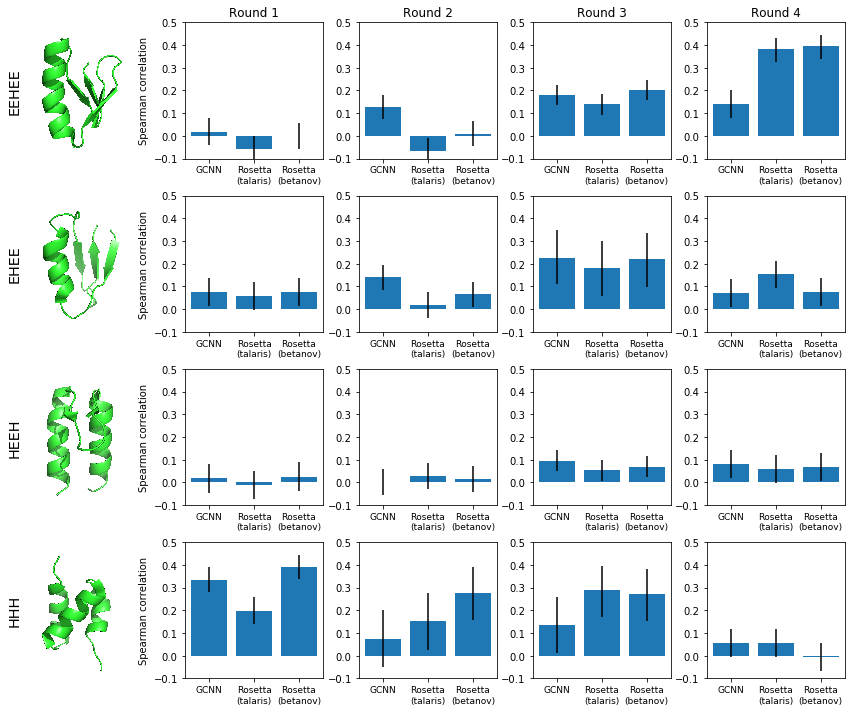

In [45]:
fg, axs = plt.subplots(4, 5, sharex=False, figsize=(12, 10))
domains = ["EEHEE", "EHEE", "HEEH", "HHH"]
for i, domain in enumerate(domains):
    for j, library in enumerate([None, "rd1", "rd2", "rd3", "rd4"]):
        ax = axs[i, j]
        if i == 0 and j > 0:
            ax.set_title(f"Round {j}")
        if j == 0:
            img = mpimg.imread(
                (
                    INPUT_PATH
                    / "global_analysis_of_protein_folding"
                    / "aan0693_designed-PDB-files"
                    / "nmr"
                    / f"{domain}.png"
                ).as_posix()
            )
            ax.imshow(img)
            ax.axis("off")
            ax.set_xlim(500, 3500)
            ax.set_ylim(4250, -400)
            ax.text(
                -0.25,
                0.5,
                domain,
                rotation=90,
                fontsize="x-large",
                horizontalalignment="center",
                verticalalignment="center",
                transform=ax.transAxes,
            )
        else:
            df = results_df[(results_df["domain"] == domain) & (results_df["library"] == library)]
            data = df["corr"].values
            data = [data[0]] + (-data[1:]).tolist()
            ax.bar([1, 2, 3], data, yerr=df[["corr_conf_upper", "corr_conf_lower"]].values.T)
            ax.set_ylim(-0.1, 0.5)
            ax.set_xticks([1, 2, 3])
            if j == 1:
                ax.set_ylabel("Spearman correlation")
            ax.set_xticklabels(["GCNN", "Rosetta\n(talaris)", "Rosetta\n(betanov)"], fontsize=9)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath("correlations_with_designs.svg"), dpi=2000)
fg.savefig(NOTEBOOK_PATH.joinpath("correlations_with_designs.pdf"), dpi=2000)
fg.savefig(NOTEBOOK_PATH.joinpath("correlations_with_designs.png"), dpi=2000)

In [46]:
for library_name in list(stability_scores)[:4]:
    df = stability_scores[library_name][
        (stability_scores[library_name]["sum_log_prob"].isnull())
        & ((stability_scores[library_name]["talaris2013_score"].notnull()))
    ]
    print(library_name, len(df))

KeyError: 'sum_log_prob'

In [ ]:
for library_name in list(stability_scores)[:4]:
    df = stability_scores[library_name][
        (stability_scores[library_name]["sum_log_prob"].notnull())
        & ((stability_scores[library_name]["talaris2013_score"].isnull()))
    ]
    print(library_name, len(df))

In [ ]:
for library_name in list(stability_scores)[:4]:
    df = stability_scores[library_name][
        ((stability_scores[library_name]["talaris2013_score"].isnull()))
    ]
    print(library_name, len(df))